In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.amp import autocast, GradScaler

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mixed Precision을 위한 스케일러 초기화
scaler_resnet_50 = GradScaler('cuda')
scaler_se_resnet_50 = GradScaler('cuda')

batch_size = 512 # 배치 크기

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터셋 다운로드
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 증강
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 검증/테스트 데이터
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 데이터셋 다운로드
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda


In [11]:
from torch.utils.data import random_split

# Train/Validation 분할 (80:20)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

datasets = random_split(full_trainset, [train_size, val_size])
trainset = datasets[0]  # 학습용
valset = datasets[1]     # 검증용


# 데이터셋 불러오기
# DataLoader : 데이터셋을 배치 단위로 관리하는 역할
    # batch_size : 배치 크기
    # shuffle : 데이터를 섞을지 여부
    # num_workers : 데이터 로드에 사용할 쓰레드 수
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
import torch
import torch.nn as nn

# SEBlock : Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Squeeze

        # Excitation
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        z = self.avg_pool(x).view(b, c) # 딥러닝에서는 이미지를 batch 수 만큼 한번에 진행
        s = self.fc(z).view(b, c, 1, 1) # 채널 수 만큼 출력
        return x * s # scale

In [13]:
import torch.nn.functional as F

class ResNetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, use_se=False, reduction=16):
        super(ResNetBottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # SEBlock 추가 여부
        if use_se:
            self.se = SEBlock(planes * self.expansion, reduction)
        else:
            self.se = nn.Identity() # SEBlock 추가 안할 경우 그냥 통과

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [14]:
class Net(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_se=False, reduction=16):
        super(Net, self).__init__()
        self.in_planes = 64

        # 채널 수 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # _make_layer 함수 호출하여 여러 개의 블록 그룹 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1, use_se, reduction)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2, use_se, reduction)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2, use_se, reduction)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2, False, reduction) # 마지막 블록은 SEBlock 추가 안함

        # average pooling 레이어 사용
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 완전 연결 레이어(Fully Connected Layer) 512 * block.expansion -> 10개의 클래스로 분류
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, use_se=False, reduction=16):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 블록은 stride, 나머지는 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, use_se, reduction))
            self.in_planes = planes * block.expansion # 채널 수 증가
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [15]:
# 50 layer resnet
resnet_50 = Net(ResNetBottleneck, [3, 4, 6, 3])
resnet_50_loss = []
resnet_50_error = []

se_resnet_50 = Net(ResNetBottleneck, [3, 4, 6, 3], use_se=True, reduction=16)
se_resnet_50_loss = []
se_resnet_50_error = []

# 모델을 GPU로 이동
resnet_50 = resnet_50.to(device)
se_resnet_50 = se_resnet_50.to(device)

In [16]:
import torch.optim as optim
import numpy as np

# 크로스 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()

# 초기 학습률을 더 낮게 설정 (경사 폭발 방지)
# ResNet-50과 같은 깊은 네트워크에서는 더 보수적인 접근 필요

# 모멘텀 0.9, weight_decay 1e-4
resnet_50_optimizer = optim.SGD(resnet_50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
se_resnet_50_optimizer = optim.SGD(se_resnet_50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# 학습률 스케줄링 - 더 적극적으로 설정
# patience를 줄이고 factor를 더 작게 해서 더 자주, 더 크게 감소
resnet_50_scheduler = optim.lr_scheduler.ReduceLROnPlateau(resnet_50_optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)
se_resnet_50_scheduler = optim.lr_scheduler.ReduceLROnPlateau(se_resnet_50_optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)

# 100번 에포크 학습
num_epochs = 100

In [17]:
# 평가 함수 (top1 error rate, top5 error rate)
def evaluate_model(model, data_loader, is_top5=False):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # GPU로 이동
            labels = labels.to(device)  # GPU로 이동
            
            outputs = model(inputs)
            
            if is_top5:
                _, top5 = outputs.topk(5, dim=1)
                total_correct += (top5 == labels.unsqueeze(1)).any(dim=1).sum().item()
            else:
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    return (1 - total_correct / total_samples) * 100           

In [18]:
# SE-ResNet-50 model 학습 (스케줄링 적용)
for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정
    se_resnet_50.train()
    
    running_loss_se_resnet_50 = 0.0
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current LR - SE-ResNet50: {se_resnet_50_optimizer.param_groups[0]['lr']:.6f}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # GPU로 이동
        labels = labels.to(device)  # GPU로 이동

        # SE-ResNet-50 학습 (Mixed Precision)
        se_resnet_50_optimizer.zero_grad()

        # Mixed Precision 순전파
        with autocast('cuda'):
            outputs_se_resnet_50 = se_resnet_50(inputs)
            loss_se_resnet_50 = criterion(outputs_se_resnet_50, labels)
        
        # Mixed Precision 역전파
        scaler_se_resnet_50.scale(loss_se_resnet_50).backward()
        scaler_se_resnet_50.step(se_resnet_50_optimizer)
        scaler_se_resnet_50.update()
    

        # 배치 손실 합계 계산
        running_loss_se_resnet_50 += loss_se_resnet_50.item()

        # 20 배치마다 검증 및 출력
        if (i + 1) % 20 == 0:
            val_error_se_resnet_50 = evaluate_model(se_resnet_50, val_loader)

            se_resnet_50_error.append(val_error_se_resnet_50)

            avg_loss_se_resnet_50 = running_loss_se_resnet_50 / 20
            
            se_resnet_50_loss.append(avg_loss_se_resnet_50)

            print(f"Batch {i + 1}: SE-ResNet50 Loss = {avg_loss_se_resnet_50:.4f}, Error = {val_error_se_resnet_50:.2f}%")
            
            # running_loss 초기화
            running_loss_se_resnet_50 = 0.0
    
    # 에포크 끝에서 스케줄러 업데이트 (검증 오류율 기준)
    if len(se_resnet_50_error) > 0:
        se_resnet_50_scheduler.step(se_resnet_50_error[-1])

print("학습 완료!")


Epoch 1/100
Current LR - SE-ResNet50: 0.001000
Batch 20: SE-ResNet50 Loss = 2.2839, Error = 89.80%
Batch 40: SE-ResNet50 Loss = 2.3202, Error = 89.74%
Batch 60: SE-ResNet50 Loss = 2.2752, Error = 82.67%

Epoch 2/100
Current LR - SE-ResNet50: 0.001000
Batch 20: SE-ResNet50 Loss = 2.2130, Error = 81.85%
Batch 40: SE-ResNet50 Loss = 2.0764, Error = 73.54%
Batch 60: SE-ResNet50 Loss = 1.9253, Error = 70.01%

Epoch 3/100
Current LR - SE-ResNet50: 0.001000
Batch 20: SE-ResNet50 Loss = 1.8998, Error = 68.23%
Batch 40: SE-ResNet50 Loss = 1.8279, Error = 68.62%
Batch 60: SE-ResNet50 Loss = 1.7886, Error = 66.94%

Epoch 4/100
Current LR - SE-ResNet50: 0.001000
Batch 20: SE-ResNet50 Loss = 1.7384, Error = 66.03%
Batch 40: SE-ResNet50 Loss = 1.7266, Error = 62.88%
Batch 60: SE-ResNet50 Loss = 1.7404, Error = 65.03%

Epoch 5/100
Current LR - SE-ResNet50: 0.001000
Batch 20: SE-ResNet50 Loss = 1.6189, Error = 66.11%
Batch 40: SE-ResNet50 Loss = 1.6793, Error = 59.30%
Batch 60: SE-ResNet50 Loss = 1.6

In [19]:
# SE-ResNet-50 model 저장
torch.save(se_resnet_50.state_dict(), 'se_resnet_50.pth')

In [20]:
# ResNet-50 model 학습 (Mixed Precision 적용)
for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정
    resnet_50.train()
    
    running_loss_resnet_50 = 0.0
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current LR - ResNet50: {resnet_50_optimizer.param_groups[0]['lr']:.6f}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  # GPU로 이동
        labels = labels.to(device)  # GPU로 이동

        # ResNet-50 학습 (Mixed Precision)
        resnet_50_optimizer.zero_grad()
        
        # Mixed Precision 순전파
        with autocast('cuda'):
            outputs_resnet_50 = resnet_50(inputs)
            loss_resnet_50 = criterion(outputs_resnet_50, labels)
        
        # Mixed Precision 역전파
        scaler_resnet_50.scale(loss_resnet_50).backward()
        scaler_resnet_50.step(resnet_50_optimizer)
        scaler_resnet_50.update()

        # 배치 손실 합계 계산
        running_loss_resnet_50 += loss_resnet_50.item()

        # 20 배치마다 검증 및 출력
        if (i + 1) % 20 == 0:
            val_error_resnet_50 = evaluate_model(resnet_50, val_loader)

            resnet_50_error.append(val_error_resnet_50)

            avg_loss_resnet_50 = running_loss_resnet_50 / 20
            
            resnet_50_loss.append(avg_loss_resnet_50)

            print(f"Batch {i + 1}: ResNet50 Loss = {avg_loss_resnet_50:.4f}, Error = {val_error_resnet_50:.2f}%")
            
            # running_loss 초기화
            running_loss_resnet_50 = 0.0
    
    # 에포크 끝에서 스케줄러 업데이트 (검증 오류율 기준)
    if len(resnet_50_error) > 0:
        resnet_50_scheduler.step(resnet_50_error[-1])

print("학습 완료!")


Epoch 1/100
Current LR - ResNet50: 0.001000
Batch 20: ResNet50 Loss = 2.3140, Error = 89.80%
Batch 40: ResNet50 Loss = 2.3156, Error = 89.15%
Batch 60: ResNet50 Loss = 2.2806, Error = 78.65%

Epoch 2/100
Current LR - ResNet50: 0.001000
Batch 20: ResNet50 Loss = 2.2595, Error = 83.78%
Batch 40: ResNet50 Loss = 2.0959, Error = 75.84%
Batch 60: ResNet50 Loss = 2.0064, Error = 72.97%

Epoch 3/100
Current LR - ResNet50: 0.001000
Batch 20: ResNet50 Loss = 2.0005, Error = 76.52%
Batch 40: ResNet50 Loss = 1.9526, Error = 75.59%
Batch 60: ResNet50 Loss = 2.1218, Error = 72.40%

Epoch 4/100
Current LR - ResNet50: 0.001000
Batch 20: ResNet50 Loss = 1.8573, Error = 69.85%
Batch 40: ResNet50 Loss = 1.8691, Error = 69.54%
Batch 60: ResNet50 Loss = 1.8578, Error = 75.24%

Epoch 5/100
Current LR - ResNet50: 0.001000
Batch 20: ResNet50 Loss = 1.8135, Error = 71.46%
Batch 40: ResNet50 Loss = 1.8283, Error = 67.49%
Batch 60: ResNet50 Loss = 1.8255, Error = 69.64%

Epoch 6/100
Current LR - ResNet50: 0.00

In [21]:
# ResNet-50 model 저장
torch.save(resnet_50.state_dict(), 'resnet_50.pth')

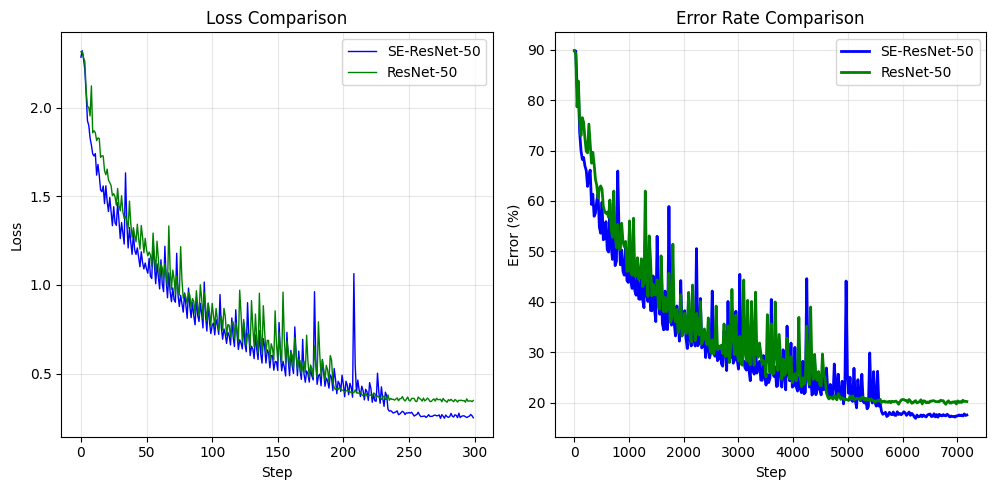

In [24]:
import matplotlib.pyplot as plt

# SE-ResNet과 ResNet 비교 그래프
plt.figure(figsize=(15, 5))
# 손실 비교 그래프
plt.subplot(1, 3, 1)
plt.plot(se_resnet_50_loss, label='SE-ResNet-50', color='blue', linewidth=1)
plt.plot(resnet_50_loss, label='ResNet-50', color='green', linewidth=1)
plt.title("Loss Comparison")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율 step x 값 보정
x_values = [i * 24 for i in range(len(resnet_50_error))]

# 오류율 비교 그래프
plt.subplot(1, 3, 2)
plt.plot(x_values, se_resnet_50_error, label='SE-ResNet-50', color='blue', linewidth=2)
plt.plot(x_values, resnet_50_error, label='ResNet-50', color='green', linewidth=2)
plt.title("Error Rate Comparison")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# 최종 테스트 오류율 비교
resnet_50_test_top1_error = evaluate_model(resnet_50, test_loader)  
se_resnet_50_test_top1_error = evaluate_model(se_resnet_50, test_loader)

resnet_50_test_top5_error = evaluate_model(resnet_50, test_loader, is_top5=True)
se_resnet_50_test_top5_error = evaluate_model(se_resnet_50, test_loader, is_top5=True)

print(f"ResNet-50 Top1 Error: {resnet_50_test_top1_error:.2f}%, Top5 Error: {resnet_50_test_top5_error:.2f}%")
print(f"SE-ResNet-50 Top1 Error: {se_resnet_50_test_top1_error:.2f}%, Top5 Error: {se_resnet_50_test_top5_error:.2f}%")

ResNet-50 Top1 Error: 20.06%, Top5 Error: 1.00%
SE-ResNet-50 Top1 Error: 17.21%, Top5 Error: 0.68%
